In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as mst
from scipy.interpolate import interp1d
from cycler import cycler
from lmfit import Parameters, minimize


def load (initpath,datei,skip,separation):
    
    initpath= initpath +"/" + datei
    temp_df = np.array(pd.read_csv(initpath, comment='~', skiprows=skip, sep=separation,
                           encoding='latin1', header=None, on_bad_lines='skip',
                           decimal='.'))
    return temp_df
    
           
def read_datafiles(cellname):
    dataset = []
    testdata = {}
    eisdata = []
    fileVar = []
    celldata={}
    
    # initpath = r"C:\Users\Dominik\tubCloud\Arbeitsplatz\Skripte\Daten\Zahner"
    initpath= r"C:\Users\maxim\Nextcloud\Shared\Austausch_Max\Projekt_Entropie\EIS\Data"
    folderpath = initpath + "/" + cellname
    folders = os.listdir(folderpath)
    for folder in folders:
        path = folderpath + "/" + folder
        files = os.listdir(path)
        for file in (f for f in files if f.endswith("01.txt")):
            fileVar.append(file)
            with open(path + "/" + file, 'r') as f:
                lines = f.readlines()
                limits = [idx for idx, data in enumerate(lines) if 'Number' in data]
                data = lines[limits[0]+1:-1] 
                #Now, you can parse the lines into rows by splitting the line on whitespace
                rows = [line.split() for line in data]
                eisdata = np.array(rows, dtype=float)
            key = [p.split(".")[0] for p in file.split("_") if "mV" in p][0]
            testdata[key]=eisdata
            eisdata = []
        key_folder = folder.split("_", 2)[-1]  # z.B.→ '25grad'
        celldata[key_folder] = testdata
        testdata = {}
    #dataset.append(testdata)
    return celldata, folders, fileVar

def get_Voltagevalues(filenames):
    newName = []
    for i in range(len(filenames)):
        new = filesCell1[i].split(".")
        new = new[0][-6:]
        newName.append(new)
    #newName = newName[i][0]
    return newName  

def get_Voltagevalues60(filenames):
    newName = []
    for i in range(len(filenames)):
        new = filesCell3[i].split(".")
        new = new[0][-6:]
        newName.append(new)
    #newName = newName[i][0]
    return newName      

def getmOhm(data):
    newdata = data
    for i in range(len(data)):
        for j in range(len(data[i][0])):
            #data.append(dataCell1[0][2][i]*1000)
            newdata[i][2][j] = data[i][2][j] * 1000
            newdata[i][3][j] = data[i][3][j] * 1000
    return newdata

def interpFre(data):
    xq = np.arange(min(data[1]),max(data[1])+min(data[1]), 1)
    x = np.array(data[1], dtype=float)
    yre = data[2]
    yim = data[3]
    vqre = interp1d(x, yre)
    vqim = interp1d(x, yim)
    yintre = vqre(xq)
    yintim = vqim(xq)
    a = np.array([xq, yintre, yintim])

    b = min(yintim, key=abs)
    c = xq[np.where(yintim == b)]
    return c

def getFre(data):
    freIm = []
    for i in range(len(data)):
        minImInd = np.where(np.array(data[i][3]) == min(data[i][3], key=abs))[0]
        minImf = data[i][1][int(minImInd)]
        freIm.append(minImf)
    return freIm


Daten einlesen

In [2]:
cellname = "46Ah_cell1"
dataCell1, foldersCell1, filesCell1 = read_datafiles(cellname)
data={}
for i in ["46Ah_cell1", "46Ah_cell2","60Ah_cell1", "60Ah_cell3"]:
    data[i], folders, files = read_datafiles(i)
    print(f"Data for {i}:")
    # print(data[i])
    print(data[i].keys())
    keys = list(data[i].keys())
    print(data[i][keys[0]].keys())

Data for 46Ah_cell1:
dict_keys(['25grad', '30grad', '35grad'])
dict_keys(['3553mV', '3698mV', '3941mV', '4200mV'])
Data for 46Ah_cell2:
dict_keys(['25grad', '30grad', '35grad'])
dict_keys(['3556mV', '3702mV', '3945mV', '4200mV'])
Data for 60Ah_cell1:
dict_keys(['messung1', 'messung2'])
dict_keys(['2700mV', '3350mV', '3410mV', '3460mV', '3505mV', '3540mV', '3566mV', '3587mV', '3610mV', '3625mV', '3650mV', '3680mV', '3720mV', '3770mV', '3822mV', '3830mV', '3880mV', '3935mV', '3990mV', '4050mV', '4110mV', '4200mV'])
Data for 60Ah_cell3:
dict_keys(['messung1'])
dict_keys(['2700mV', '3412mV', '3505mV', '3566mV', '3606mV', '3647mV', '3718mV', '3830mV', '3935mV', '4050mV', '4200mV'])


Plots pro Zelle

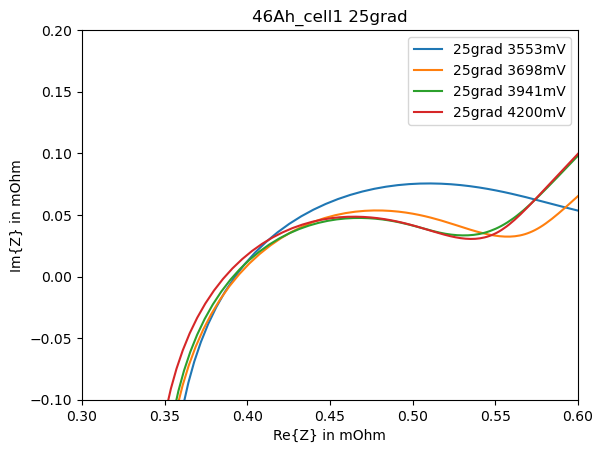

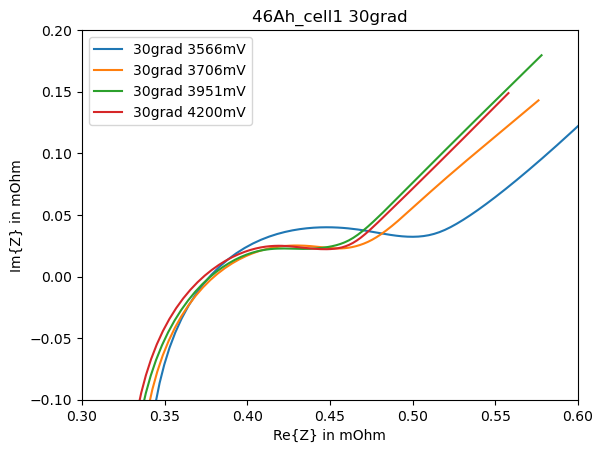

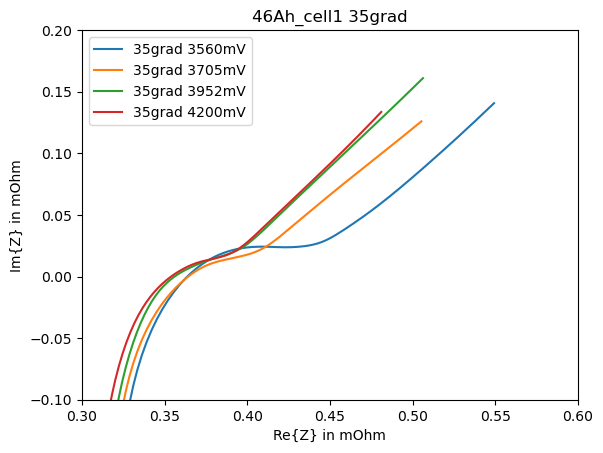

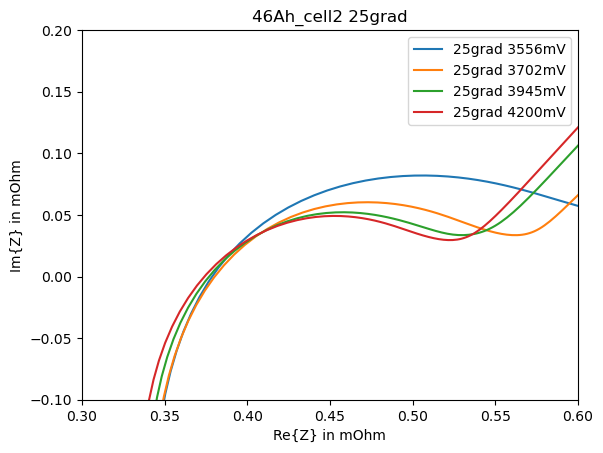

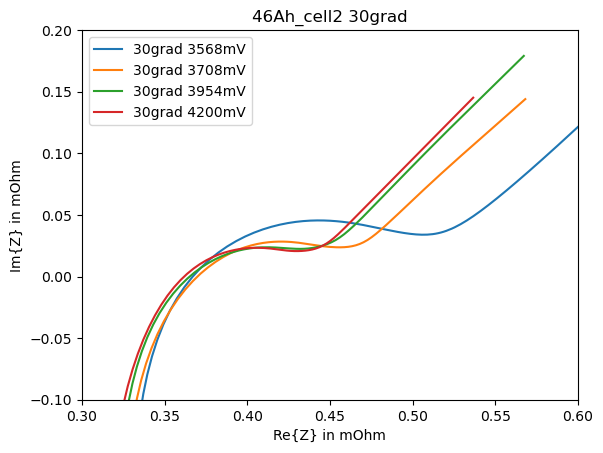

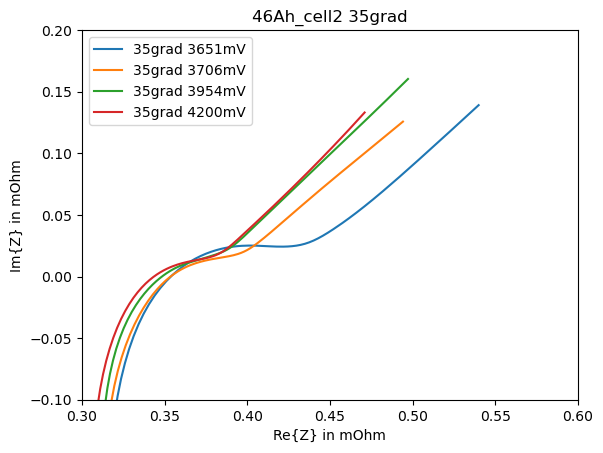

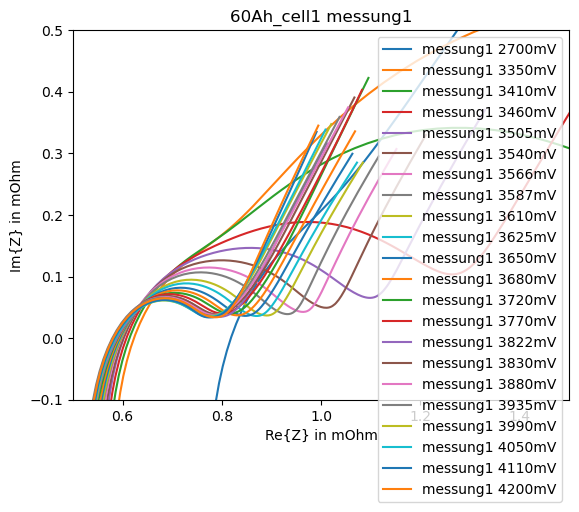

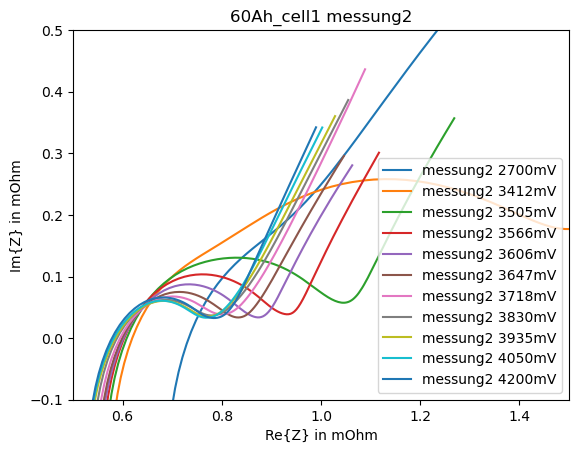

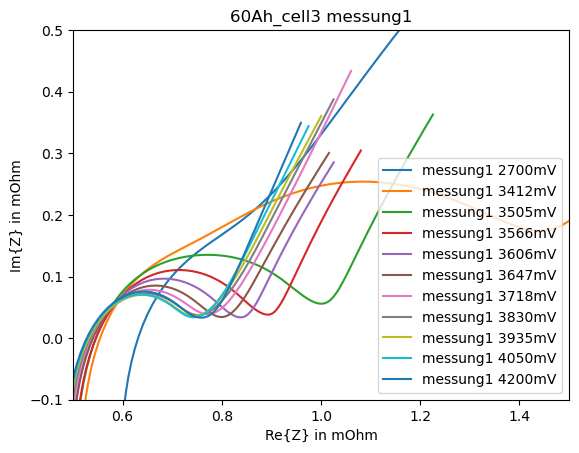

In [3]:
for cell in data.keys():
    for t in data[cell].keys():
        plt.figure()
 
        for i in data[cell][t].keys():
            plt.plot(data[cell][t][i][:,2]*1000, np.negative(data[cell][t][i][:,3])*1000, label=f"{t} {i}")
        plt.xlabel("Re{Z} in mOhm")
        plt.ylabel("Im{Z} in mOhm")
        if "60" in cell:
            plt.ylim(-0.1, 0.5)
            plt.xlim(0.5, 1.5)
        else:
            plt.ylim(-0.1, 0.2)
            plt.xlim(0.3, 0.6)
        plt.title(cell+" "+t)
        plt.legend()
        plt.show()

1. Basierend auf der Impedanzspektrumsanalyse und der visuellen Interpretation des Nyquist-Diagramms wird das elektrochemische System durch folgende Ersatzschaltung modelliert:

\begin{equation}
Z(j\omega) = R_0 + j\omega L_0 + 
\underbrace{\frac{R_1}{1 + (j\omega A_1)^{p_1}}}_{\text{ZARC}_1} +
\underbrace{\frac{R_2}{1 + (j\omega A_3)^{p_2}}}_{\text{ZARC}_2} +
\underbrace{A_2 (j\omega)^{-1/2}}_{\text{Warburg}}
\end{equation}

R0 ------ Ohmscher Serienwiderstand

L0 ------ Induktivität

ZARC1 ZARC2 ----- Der ZARC besteht aus einem phasenkonstanten Element (CPE), das parallel zu einem Widerstand R

Warburg element ------Diffusionskontrollierter Prozess

2. Fehlerfunktion (Residual) definieren:

   \begin{equation}
   \text{residual} = \Re(Z_{\text{modell}} - Z_{\text{exp}}) \, \Vert \, \Im(Z_{\text{modell}} - Z_{\text{exp}})
   \end{equation}

Der Residualvektor setzt sich aus dem Real- und Imaginärteil der Differenz zusammen.(mittels np.concatenate() )

3. lmfit.minimize führt die Anpassung durch und gibt die optimierten Parameter aus.



46Ah_cell1 25grad:

3553mV fertig
3698mV fertig
3941mV fertig
4200mV fertig
             R0            L0            RL        R1        A1        p1  \
U                                                                           
3.553  0.000338  8.583880e-08  2.113584e+09  0.000116  0.001833  0.973182   
3.698  0.000335  8.554711e-08  3.775123e+05  0.000145  0.001766  0.934879   
3.941  0.000318  8.834318e-08  1.101819e-02  0.000169  0.001775  0.857553   
4.200  0.000315  8.718833e-08  1.176456e-02  0.000164  0.001781  0.859933   

             R2           A3        p2     A2        R3         A4        p3  
U                                                                             
3.553  0.006557  1078.216786  0.567254  0.001  0.000165   0.007813  0.711592  
3.698  0.000083     0.010063  0.671519  0.001  0.001595  70.844989  0.659047  
3.941  0.001515    35.577221  0.741227  0.001  0.000077   0.030714  0.500000  
4.200  0.001466    48.340553  0.722760  0.001  0.000073   0.01418

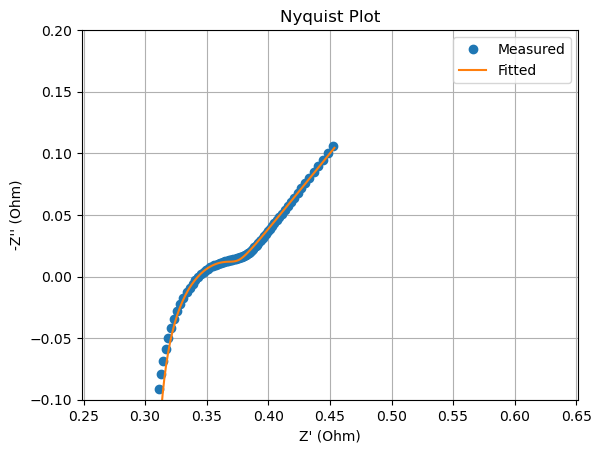

In [166]:
# Enthält zwei ZARCs und einen Warburg.
def Z_model(params, omega):
    R0 = params['R0']
    L0 = params['L0']
    RL = params['RL']  
    R1 = params['R1']
    A1 = params['A1']
    p1 = params['p1']
    R2 = params['R2']
    A3 = params['A3']
    p2 = params['p2']
    R3 = params['R3']
    A4 = params['A4']
    p3 = params['p3']
    A2 = params['A2'] 

    jw = 1j * omega
    Z_L = (RL * jw * L0) / (RL + jw * L0)
    Z_ZARC1 = R1 / (1 + (jw * A1)**p1)
    Z_ZARC2 = R2 / (1 + (jw * A3)**p2)
    Z_ZARC3 = R3 / (1 + (jw * A4)**p3)
    Z_W = A2 * (jw ** -0.5)

    Z_total = R0 + Z_L + Z_ZARC1 + Z_ZARC2 + Z_ZARC3 
    return Z_total
# Residual definieren
def residual(params, omega, data):
    model = Z_model(params, omega)
    return np.concatenate([(model.real - data.real), (model.imag - data.imag)])




fit_data = {}
plot_data={}
for cell in ["46Ah_cell1", "46Ah_cell2"]:
    fit_data[cell] = {}
    plot_data[cell] = {}
    for t in data[cell].keys():
        plot_data[cell][t] = {}
        print("\n"+cell+" "+t+":\n")
        results_list = []
        for i in data[cell][t].keys():
                        
            test=data[cell][t][i]
            frequencies = test[:,1]  # Hz
            if "60Ah" in cell:
                max_freq=np.where(frequencies>1000)[0][0]
                min_freq=np.where(frequencies<0.018)[0][-1]
            else:
                max_freq=np.where(frequencies>800)[0][0]
                min_freq=np.where(frequencies<0.08)[0][-1]
            # print(max_freq)
            # print(min_freq)

            # Frequenz in Kreisfrequenz umrechnen
            frequencies = test[min_freq:max_freq,1]  # Hz
            omega = 2 * np.pi * frequencies
            # Messdaten als komplexe Impedanz interpretieren
            Z_real = test[min_freq:max_freq,2]
            Z_imag = test[min_freq:max_freq,3]
            Z_exp = Z_real + 1j * Z_imag


            #---
            #Prefit
            #---
            # Anfangsparameter
            params_pre = Parameters()
            params_pre.add('R0', value=0.05, min=0)
            params_pre.add('L0', value=1e-6, min=0)
            params_pre.add('RL', value=0.1, min=0)
            params_pre.add('R1', value=0.1, min=0)
            params_pre.add('A1', value=1e-3, min=1e-6)
            params_pre.add('p1', value=0.9, min=0.5, max=1)
            params_pre.add('R2', value=0.05, min=0)
            params_pre.add('A3', value=1e-2, min=1e-6)
            params_pre.add('p2', value=0.8, min=0.5, max=1)
            params_pre.add('A2', value=1e-3, min=1e-6)
            params_pre.add('R3', value=0.05, min=0)
            params_pre.add('A4', value=1e-3, min=1e-6)
            params_pre.add('p3', value=0.8, min=0.5, max=1)

            # wichtig ist Standardfehler
            result_pre = minimize(residual, params_pre, args=(omega, Z_exp))
            # print("\n Prefit: \n")
            # result_pre.params.pretty_print()
            #Berechnung der Modellimpedanz für gegebene Frequenzen mit den optimierten Parametern.
            Z_fit_pre = Z_model(result_pre.params, omega)

            #---
            # Fit
            #---
            # Anfangsparameter aus Prefit
            params = Parameters()
            params.add('R0', value=result_pre.params['R0'].value, min=0)
            params.add('L0', value=result_pre.params['L0'].value, min=0)
            params.add('RL', value=result_pre.params['RL'].value, min=0)
            params.add('R1', value=result_pre.params['R1'].value, min=0)
            params.add('A1', value=result_pre.params['A1'].value, min=1e-6)
            params.add('p1', value=result_pre.params['p1'].value, min=0.5, max=1)
            params.add('R2', value=result_pre.params['R2'].value, min=0)
            params.add('A3', value=result_pre.params['A3'].value, min=1e-6)
            params.add('p2', value=result_pre.params['p2'].value, min=0.5, max=1)
            params.add('A2', value=result_pre.params['A2'].value, min=1e-6)
            params.add('R3', value=result_pre.params['R3'].value, min=0)
            params.add('A4', value=result_pre.params['A4'].value, min=1e-6)
            params.add('p3', value=result_pre.params['p3'].value, min=0.5, max=1)

            result = minimize(residual, params, args=(omega, Z_exp))
            # print("\n Fit: \n")
            # result.params.pretty_print()
            Z_fit = Z_model(result.params, omega)
            plot_data[cell][t][i] = Z_fit

            param_values = {name: param.value for name, param in result.params.items()}
            param_values["U"] = float(i.replace("mV", "")) / 1000

            results_list.append(param_values)
            print(i + " fertig")
        # Alles in einen DataFrame
        df = pd.DataFrame(results_list)

        # Optional: Spannung als Index setzen
        df.set_index("U", inplace=True)

        print(df)
        fit_data[cell][t] = df


plt.figure()
plt.plot(Z_exp.real*1000, -Z_exp.imag*1000, 'o', label='Measured')
plt.plot(Z_fit.real*1000, -Z_fit.imag*1000, '-', label='Fitted')
plt.xlabel("Z' (Ohm)")
plt.ylabel("-Z'' (Ohm)")
plt.axis("equal")
plt.title("Nyquist Plot")
if "60Ah" in cell:
    plt.ylim(-0.1, 0.5)
    plt.xlim(0.5, 1.5)
else:
    plt.ylim(-0.1, 0.2)
    plt.xlim(0.3, 0.6)
plt.legend()
plt.grid(True)

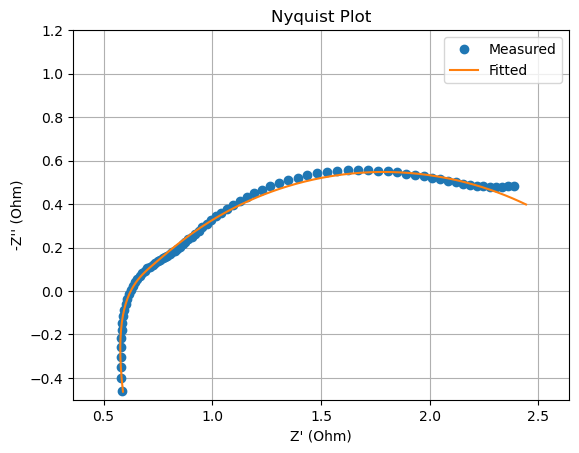

In [103]:
plt.figure()
plt.plot(Z_exp.real*1000, -Z_exp.imag*1000, 'o', label='Measured')
plt.plot(Z_fit.real*1000, -Z_fit.imag*1000, '-', label='Fitted')
plt.xlabel("Z' (Ohm)")
plt.ylabel("-Z'' (Ohm)")
plt.axis("equal")
plt.title("Nyquist Plot")
plt.ylim(-0.5, 1.2)
plt.xlim(0.2, 2.8)
plt.legend()
plt.grid(True)